# LSTMtextgenerator

The focus of this project is to develop a working text generator using a Long Short Term Memory Recurrent Neural Network.  Keep in mind this is a **student-like** approach to LSTM text generation and should be taken accordingly.  Let's start by importing some libraries used troughtout the notebook. 

In [1]:
### Import libraries
import torch
from torch import optim
import torch.nn.functional as F
from collections import Counter
import os
import torch.nn as nn
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from random import choice
from sklearn.manifold import TSNE

Firstly, we'll obtain our training data. This consist into a book (I've used *Alice in Wonderland* and *Pride and Prejudice* obtained from *project Gutenberg*, but any book in .txt format will do as good), which is going to be tokenized into words. This is done by the method *corpus()*:

In [2]:
## Produce the corpus of the training data
def corpus(train_file):
      
    # Read the text file 
    with open(train_file, 'r') as f:
        clean_txt = f.read().lower().replace('\n', ' \n ')

    # clean up the text (lower the uppercases, remove all the digits, special characters, and extra spaces from the text)
    #clean_txt = re.sub('[^A-Za-z]+', ' ', clean_txt)  ##not really needed when embedding
    clean_txt = re.sub(r'\s+', ' ', clean_txt) # Eliminate duplicate whitespaces

    # Tokenize the text
    words = clean_txt.split()

    return words

From those words, we'll generate two vocabularies: one which maps the each word into a specific integer, and one which converts the integer back into a word.  Those will be needed to create a word embedding later on. Note that all of the upper case letters are going to be lowered, since it would result in having words like 'sea' and 'Sea' mapped in two different indexes. 

In [3]:
## Generate the vocabularies 
def vocabs(words):
    word2idx = dict()
    idx2word = dict()
    
    sorted_vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
    
    ## Generate the vocabularies from word to int and vice versa
    for i, word in enumerate(sorted_vocab):
            word2idx[word] = i
    for i, word in enumerate(word2idx.items()):
        idx2word[i] = word
        
    return word2idx, idx2word

We'll also need a target to be able to compute the loss over our prediction. In this case, since the target of the network for each word is the following word, we'll just shift the whole input text by one word. This is done by the method *prepare_datas()*, which takes in input the two vocabularies, the input set of words, the sizze of the batch and the size of the sequence we want to consider.

In [ ]:
def prepare_datas(word2idx, idx2word, words, batch_size, seq_size):
     
    # Process the data and prepare the input and the target 
    int_text = [word2idx[w] for w in words]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    ## input[...t] -> output [..t-1]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))

    return in_text, out_text

To help the training, we group the the sequences into batches. 

In [6]:
# Put the text into batches
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

Now it's finally time to dig into our LSTM network! The main idea is to have the words (translated to integers, which are easier for our network to manipulate) passing trough an *embedding layer*, with an input size equals to the size of our vocabulary and a custom embedding size. In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. Other than offering a certain utility due to the vector representation, embeddings provide a pathways to semantics. After the embedding, we apply a single-layer long short-term memory (LSTM) RNN to the input sequence. Then there's the dense layer and finally a *LogSoftmax* layer to return the possible probabilities of the words. The forward method of the network differs a bit from the feed forward standard since we need to propagate both the cell state and the hidden state, which will be used by the LSTM layer. Since we're using a Softmax in the last layer, I chose to use *Negative Loss Likelihood* as loss criterion.  This is defined as $\ell = -\log(y)$. NLL gives low values when the output matches the target, and high values when the values of the output layer are evenly distributed and low.

In [7]:
class LSTMNetwork(nn.Module):
    
    def __init__(self, input_size, seq_size, lstm_size, embedding_size, lstm_layers=1):
        
        #Call the father function
        super(LSTMNetwork, self).__init__()
        
        # Size of the words sequence
        self.seq_size = seq_size
        
        # size of hidden layer 
        self.lstm_size = lstm_size

        # vocab size
        self.input_size = input_size
        
        # embedding layer; In an embedding, words are represented by dense vectors
        # where a vector represents the projection of the word into a continuous vector space.
        # see https://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        # see (https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            lstm_layers,
                            batch_first=True)
        
        # Define dense layer
        self.out = nn.Linear(lstm_size, input_size)
        
        # Define a softamx layer 
        self.prob = nn.LogSoftmax(dim=1)

        # Initialize weights
        self.init_weights()
        
    #Initialize weights
    def init_weights(self):
        initrange = 0.1      
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.out.bias.data.zero_()
        self.out.weight.data.uniform_(-initrange, initrange)
         
        
    def forward(self, x, prev_state, batch_size):
            
        # embedding the input
        x = self.embedding(x)
        
        # LSTM
        x, state = self.lstm(x, prev_state) 
        
        # Stack up lstm outputs
        x = x.contiguous().view(-1,self.lstm_size)
        
        # dense layer + logsoftmax
        x = self.prob(self.out(x))
        
        # reshape into (batch_size, seq_length, vocab_size)
        x = x.view(batch_size, -1, self.input_size)

        # return new cell_state and new hidden_state to propagate 
        return x, state

We also create the two functions which allow us to plot the loss graph and the empeddings map:

In [8]:
# Plot the losses over the number of epochs
def training_loss_plot(loss):

    plt.close('all')
    plt.figure(figsize=(8,6))
    plt.semilogy(loss, label='Test loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# PLot the embeddings values for the top_k words of the embedding layer    
def plot_embedding(model, top_k, idx2word):
    # load the embedding weights
    emb = model.embedding.weight.cpu().data.numpy()
    
    #calculate the distance
    tsne = TSNE(metric='cosine', random_state=123)
    embed_tsne = tsne.fit_transform(emb[:top_k, :])
    
    # PLot the embeddings and the corresponding words
    fig, ax = plt.subplots(figsize=(22, 22))
    for idx in range(top_k):
        plt.scatter(*embed_tsne[idx, :], color='steelblue')
        plt.annotate(idx2word[idx][0], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    plt.savefig('embeddings_map.png')

The train of the network is quite similar to what gets usually done in a standard feed-forward network: we reset the gradients, compute the output, calculate the loss, perform back-propagation and optimize the weights. There are however some minor changes to keep in mind. Firstly, we need to wrap the hidden states in new variables for every epoch, to detach them from their history. When we call the model to obtain the output and the current state, we need to remember to pass the previous state too. RNNs are also subjected to the so-called *exploding gradient*: the gradient may jump too high and break the learning process. Therefore we apply *gradient clipping*: this consists in rescaling the gradients given a chosen vector norm and clipping gradient values that exceed a preferred range.

In [9]:
# Train the network 
def training(model, in_text, out_text, batch_size, seq_size):
    
    losses = []
    iteration = 0
    
    for epoch in range(epochs):

        batches = get_batches(in_text, out_text, batch_size, seq_size)
        
        ## Wraps hidden states in new Variables, to detach them from their history
        state_h, state_c = torch.zeros(1, batch_size, lstm_size), torch.zeros(1, batch_size, lstm_size)
        
        # Move to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
        total_loss = []
        
        for context, target in batches:
            
            iteration += 1

            # Tell it we are in training mode
            model.train()
            
            # reshape and move to GPU
            context = torch.LongTensor(context).to(device)
            target = torch.LongTensor(target).to(device)
            
    
            # zero the parameter gradients
            model.zero_grad()
            
            # forward propagation
            logits, (state_h, state_c) = model(context, (state_h, state_c), batch_size)

            # loss calculation
            loss = loss_fn(logits.transpose(1,2), target)
 
            state_h = state_h.detach()
            state_c = state_c.detach()

            # backpropagation
            loss.backward()
            
            #gradient clipping
            _ = torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            # weight optimization
            optimizer.step()

            # loss update 
            total_loss.append(loss.item())
                            
        print('Epoch: {}/{}'.format(epoch, epochs),
                    #'Iteration: {}'.format(iterations),
                    'Train loss: {}'.format(np.mean(total_loss)))
                            
        losses.append(np.mean(total_loss))
    print(' Training ended!!')
    return losses

Still following me so far? nice! because it's finally time to start training the network! We firstly need to define the hyperparameters of the network. The greater our embedding size, the better we'll be able to describe the semantic. The sequence size represent how many words back we are considering when choosing the 'future words'. The hidden size is the number of neuron in the LSTM layer. The number of epochs and the learning rate are pretty straightforward based on our knowledge.

In [13]:
## Initialize hyperparameters

# Training data (free books to use can be found on http://www.gutenberg.org/browse/scores/top)
#train_file = '.\\'+'wonderland.txt'
train_file = '.\\'+'pride.txt'

# size of the embedding of the word
embedding_size = 356
# Size of the batch for the batch learning
batch_size = 64
# Sequence of words to consider prior the prediction
seq_size = 10
# Learning rate of the network
lr = 0.0005
# Number of epochs
epochs = 55
# Size of the hidden layer of LSTM
lstm_size = 512

Then we call all of our fancy methods, and we create the instance of the network. We also define the loss criterion and set the learning rate.

In [14]:
## Produce the corpus of the training data
words = corpus(train_file)

# Generate vocabulary from word to int and vice versa
v1, v2 = vocabs(words)

# Generate the vocabularies and the data to give in input and output
intt, outt = prepare_datas(v1, v2, words, batch_size, seq_size)

# Use GPU if avaliable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# istance of a network
model = LSTMNetwork(len(v1), seq_size, lstm_size, embedding_size)
model = model.to(device)

#Set the LR
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#Set the loss function (CrossEntropyLoss is a good choice too)
loss_fn = nn.NLLLoss()

# Batchify the datas
batches = get_batches(intt, outt, batch_size, seq_size)

And we finally train the model. Keep in mind this might take a while.

In [16]:
# Train our network, return the mean of the losses over the epochs
loss = training(model, intt, outt, batch_size, seq_size)

Epoch: 0/55 Train loss: 7.3460231014326505
Epoch: 1/55 Train loss: 6.680503789116354
Epoch: 2/55 Train loss: 6.535563478282854
Epoch: 3/55 Train loss: 6.290643570469875
Epoch: 4/55 Train loss: 5.97963565938613
Epoch: 5/55 Train loss: 5.712354416940727
Epoch: 6/55 Train loss: 5.485711050968544
Epoch: 7/55 Train loss: 5.284326216753791
Epoch: 8/55 Train loss: 5.113254126380472
Epoch: 9/55 Train loss: 4.9297206542071175
Epoch: 10/55 Train loss: 4.743582248687744
Epoch: 11/55 Train loss: 4.567191049164417
Epoch: 12/55 Train loss: 4.397371535207711
Epoch: 13/55 Train loss: 4.231093172933541
Epoch: 14/55 Train loss: 4.06126693650788
Epoch: 15/55 Train loss: 3.896887451994653
Epoch: 16/55 Train loss: 3.7135302926979814
Epoch: 17/55 Train loss: 3.5223988084232105
Epoch: 18/55 Train loss: 3.3371861261479996
Epoch: 19/55 Train loss: 3.1590150197347007
Epoch: 20/55 Train loss: 2.9938940721399643
Epoch: 21/55 Train loss: 2.824012597401937
Epoch: 22/55 Train loss: 2.645773209777533
Epoch: 23/55 Tra

Let's plot the losses:

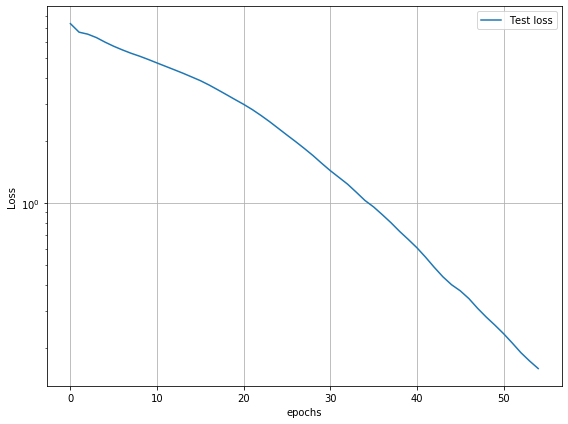

In [17]:
# plot the training loss
training_loss_plot(loss)

Embeddings can help us measure the performance of our model. That is because while the embedding layer update itself, it carries out the semantic of the text. Therefore, similar words will end up being closer to each other, (i.e *mother* and *mom*). Words with low correlation, like *fish* and *sun* will instead probably end up far from each other. Let's plot the embedding map of our model!

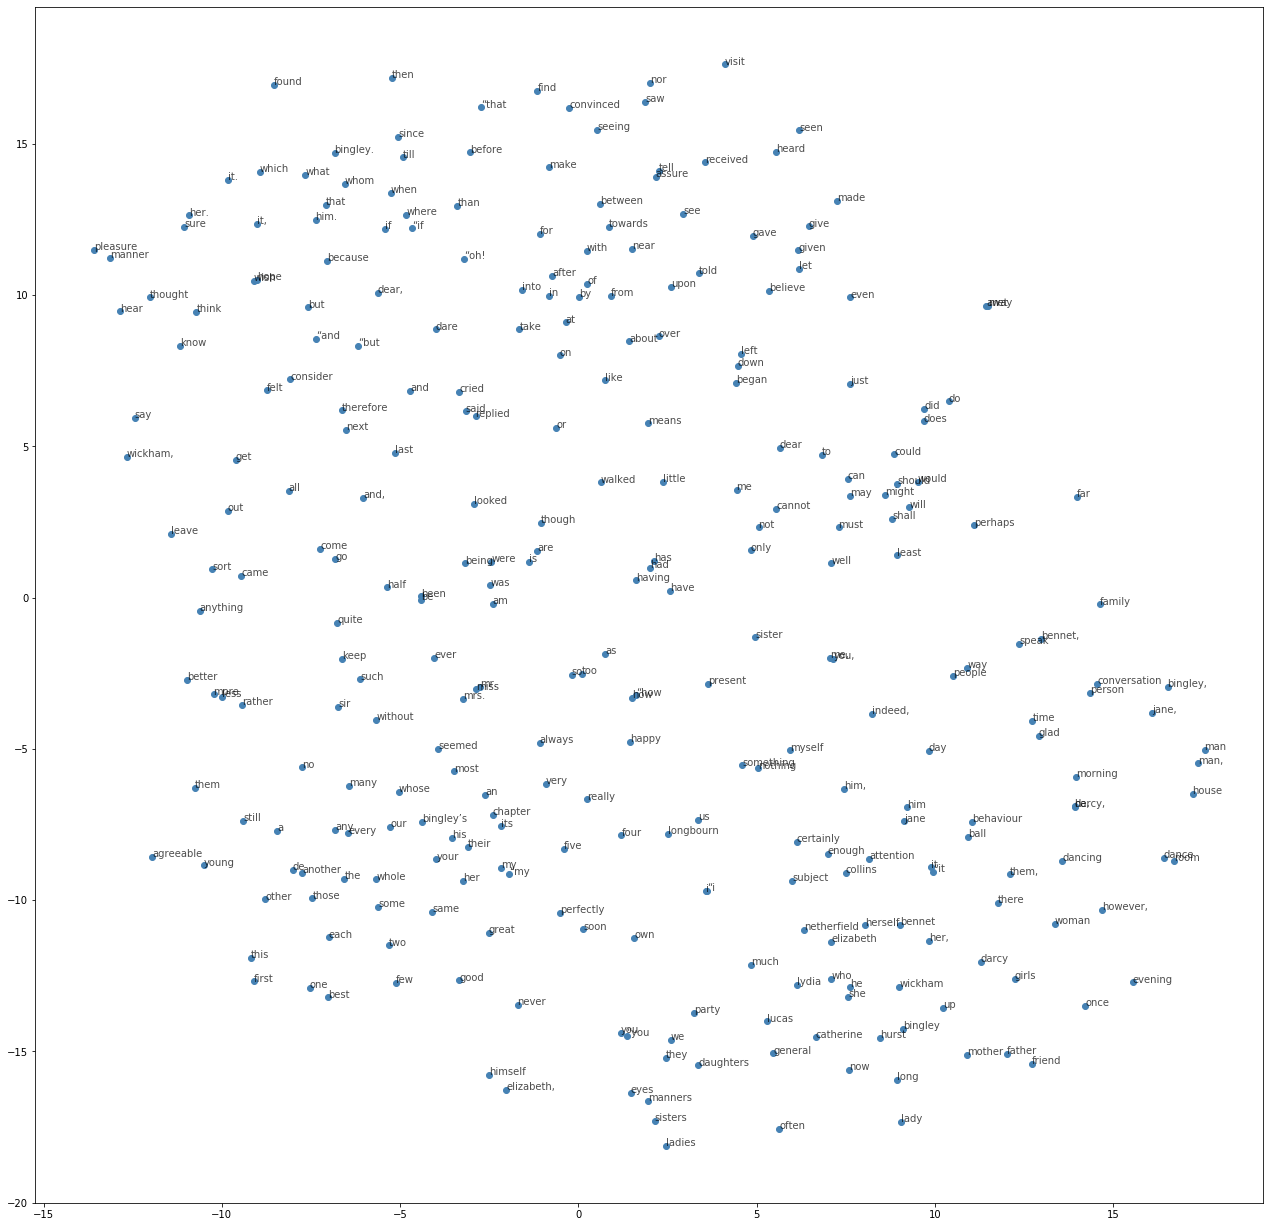

In [18]:
# plot the embeddings
plot_embedding(model, 300, v2)

Pretty nice right? We can see that the embedding layer is clearly working as expected. It's finally time to do some inference. Therefore, we define the *predict()* method. In this kind of experiment, testing the model over a test set might be not really useful due to the nature of the problem. Here, we're not looking to predict the next word, we're aiming to learn the text structure and generate somewhat coherent text. Therefore, we'll use as a performance metric the quality text we'll generate. Let's start by describing the choice of the following word. Firstly we obtain the probabilities by computing the exponential (since we're using Logarithmic Softmax), then we divide it for a parameter called *temperature*. Lower temperature will cause the model to make likely, but also stale predictions, while higher temperatures cause the model to take more chances and increase diversity of results, but a the cost of doing more mistakes. Then we compute the *multinomial distribution* over the probabilities obtained before. A multinomial distribution is similar to a binomial distribution, but can be used in situations where there are more than two possible outcomes, and it's defined as 
$$p=\frac{n!}{(n_1!)(n_2!)\ldots (n_k!)}p_1^{n_1}p_2^{n_2}\ldots p_k^{n_k}$$


In [19]:
## based on some input generate the following words
def predict(model, phrase, input_size, lenght, word2idx, idx2word, temperature, device):
    
    model.eval()

    # reset states and move to GPU
    state_h, state_c = torch.zeros(1, 1, lstm_size), torch.zeros(1, 1, lstm_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    # pass trough the input phrase 
    for w in phrase:
        word = torch.LongTensor([[word2idx[w]]]).to(device)
        output, (state_h, state_c) = model(word, (state_h, state_c), 1)
   
    # Sample from the network as a multinomial distribution
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = torch.multinomial(output_dist, 1)[0]

    # Add translated word to phrase
    phrase.append(idx2word[int(top_i)][0])
    
    for p in range(lenght):
        
        word = torch.LongTensor([[int(top_i)]]).to(device)
        
         # forward the word trough the LSTM
        output, (state_h, state_c) = model(word, (state_h, state_c), 1)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add translated word to phrase
        phrase.append(idx2word[int(top_i)][0])
   
    return phrase

Now that we've defined the criterion by which we'll pick our words over the probabilities, we can start generating some text and see how the network perform. Since our training model was the book *Pride and prejudice*, we use as a seed the phrase 'Darcy had'. Enjoy your model's personal took on the british lecterature!

In [23]:
phrase = 'Darcy had'.lower()
phrase = phrase.split()

text_generated = predict(model, phrase, len(v2), 200, v1, v2, 0.7, device)

print(' '.join(text_generated))

darcy had been gone to bingley. “i have an excellent assembly to give you so much. that mrs. long are to every other woman in the world, which is sometimes a very smart young man, with four evenings have not seen you, i can send for a compliment to the business, and a ball has been in a very orderly manner, with all the observances, which he supposed a very man and not in the room whom it should then be in the habit of hearing the very best performers.” on miss lucas’s persevering, however, she added, “very well, if it must be so, it must.” and gravely glancing at mr. darcy, “there is a fine thing in which he said, as he did elizabeth from no means a ball on her to her, that mr. wickham should be sent for the established as a man upon my dear, every times one of first sister much her to see her daughter settled that their idea had been suggested, his two sisters, “i am not in the way of your way, and if she will not be very near it to be in any real or of his family, to the particular 